# Accuracy of CERRA 10m wind data for energy application.

Production date: 09-07-2025

Produced by: Sandro Calmanti (ENEA)

## 🌍 Use case: wind-energy company using CERRA data for the preliminary evaluation of energy production

## ❓ Quality assessment question
* **How well does CERRA describe the intensity and variability of 10m wind compared to weather station data?**
* **What is the added value of CERRA 10m wind data compared to ERA5?**

The global transition towards renewable energy systems has intensified the demand for highly accurate and reliable wind resource assessments, which are fundamental for project financing, grid integration, and optimizing energy output. reanalysis datasets have emerged as indispensable tools, offering spatially and temporally comprehensive meteorological data crucial for understanding wind characteristics over extended periods [[1]](https://doi.org/10.1002/we.2759).

A growing body of literature substantiates CERRA's value for wind energy applications. Studies consistently highlight its superior performance in regional to local-scale offshore wind assessments. For instance, CERRA has demonstrated a enhanced capability to capture the wind speed variability and extreme wind events critical for energy yield prediction and structural load calculations, outperforming other reanalysis products in European seas [[2]](https://doi.org/10.2139/ssrn.5131628). 

Its high spatial and temporal resolution allows for a better representation of coastal gradients and mesoscale phenomena, leading to reduced biases in mean wind speed and power density estimates [[3]](https://doi.org/10.5194/asr-20-109-2023).

Furthermore, the utility of CERRA extends beyond pure resource assessment. Recent research has leveraged its detailed data to analyse wind conditions for ensuring the safe operation of maintenance drones within offshore wind farms, particularly in topographically complex areas like the Spanish Atlantic coast [[4]](https://doi.org/10.1016/j.energy.2025.136746). This application underscores CERRA's versatility and reliability in supporting the entire operational lifecycle of a wind farm, from initial planning to daily maintenance logistics.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* CERRA demonstrates high accuracy in reproducing 10 m wind intensity and variability across test European sites, matching ground-based weather station data and capturing regional wind characteristics more effectively than coarser global reanalyses such as ERA5.
* The enhanced spatial and temporal resolution of CERRA significantly improves the representation of wind variance campered to ERA5
* For wind energy applications, CERRA provides a clear added value through better depiction of local-scale variability and extreme wind events, supporting more reliable energy yield assessments and operational planning.

## 📋 Methodology

This notebook utilises publicly available 10 m wind data from the [European Climate Assessment & Datasets](https://www.ecad.eu/) repository (ECA&D) to evaluate the accuracy of CERRA 10 m wind data. It also outlines a sample methodology that can be adapted to assess other key variables. The analysis focuses on Norway, which offers a robust network of weather stations providing daily wind observations. Similar assessments can be extended to other national datasets or broader regional domains.

The structure of this notebook is as follows:

**[](section-1)**
 * Import libraries
 * Set parameters
 * Define data request
 * Define functions to cache

**[](section-2)**
 * Import metadata nad filter best quality weather stations
 * Import daily weather station data for target country (Norway)
 * Filter weather stations with sufficient high-rate of available records
 * Map weather stations 

**[](section-3)**
 * Import CERRA
 * Import ERA5

**[](section-4)**
 * Organize data for the analysis
 * Results
 * Discussion


## 📈 Analysis and results

(section-1)=
### 1. Set-up of the analysis

#### Import libraries

In this notebook, we use standard libraries for handling data from the Climate Data Store, such as `xarray` for NetCDF data, `c3s_eqc_automatic_quality_control` for data retrieval, and `matplotlib/cartopy` for generating charts and maps. In addition to these standard modules, the notebook incorporates weather station observations from an external source. To manage this, we use the `pooch` module, which facilitates the downloading and local storage of data files from remote sources, ensuring version control and integrity checks. We also use `pandas` for effective handling of tabular data. Statistical analyses are carried out using tools from the `scipy` package.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import tqdm
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download
from matplotlib.colors import ListedColormap
from scipy import stats

#### Set parameters

Metadata for the weather station observations from [ECA&D](https://www.ecad.eu/) are provided in a dedicated table, with columnns contain the following parameters:
* ID number and name of the weather station (`SOUID`, `SOUNAME`);
* country code (`CN`);
* coordinates and height above sea level of the weather station (`LAT`, `LON`, `HGHT`);
* quality flag indicating how the daily values is derived from sub-daily records (`ELEID`);
* starting date and ending date of the data record (`START`, `STOP`);
* ID number and name of the variable (`PARID`, `PARNAME`).

 The ID number (`SOUID`) also corresponds to the name of the file containing the daily observations.
The structure of the metadata file is described in the following dictionary.

In [2]:
# Shape of wind data-files
col_dict = {
    "SOUID": (0, 6),
    "SOUNAME": (7, 47),
    "CN": (48, 50),
    "LAT": (51, 60),
    "LON": (61, 71),
    "HGHT": (72, 76),
    "ELEID": (77, 81),
    "START": (82, 90),
    "STOP": (91, 99),
    "PARID": (100, 105),
    "PARNAME": (106, 156),
}

# Threshold for maximum allowed NaNs
max_nans = 365 * 5

#### Define data request

In this notebook, we compare weather station observations with the European reanalysis **CERRA** and the global reanalysis **ERA5**. The period over which the data are compared is constrained by the time span of CERRA, which, at the time of developing this notebook, covered the years 1984 to 2024. However, since the first and last years of CERRA's coverage are incomplete (1984 begins in September, while 2024 ends in June), the reanalysis is limited to the period for which complete years are available — namely, **1985 to 2023**.

The variable analysed in the notebook is daily 10m wind speed which is available from the ECA&D repository. 

For CERRA, the daily value of 10m wind speed needs to be computed from the 6-hourly data available from the CDS.

For ERA5, rather than retrieving large portions of the dataset and extracting time series at the nearest grid point to each weather station, it is possible to use the [ERA5 hourly time-series data on single levels from 1940 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-timeseries?tab=overview). This resource is a regridded subset of the full ERA5 dataset, specifically formatted to facilitate the efficient retrieval of long time series for individual locations. Note, however, that the 10 m wind speed variable is not directly available from ERA5 and must be computed from the u and v wind components.

The data requests are defined accordingly below.

In [3]:
# Time
start = "1985-01-01"
stop = "2020-12-31"

# CERRA
cerra_id = "reanalysis-cerra-single-levels"
cerra_request = {
    "product_type": "analysis",
    "data_type": "reanalysis",
    "level_type": "surface_or_atmosphere",
    "variable": ["10m_wind_speed"],
    "time": ["00:00", "06:00", "12:00", "18:00"],
    "data_format": "grib",
}

# ERA5
era5_id = "reanalysis-era5-single-levels-timeseries"
era5_request = {
    "variable": ["10m_u_component_of_wind", "10m_v_component_of_wind"],
    "date": [f"{start}/{stop}"],
    "data_format": "netcdf",
}

# ECA European Climate Assessment & Dataset
eca_url = "https://knmi-ecad-assets-prd.s3.amazonaws.com/download/ECA_nonblend_fg.zip"


#### Define functions to cache

A few utility functions are defined below to perform the analysis.

* **dms_to_decimal** converts the coordinates of weather stations, which are stored in a degree/minutes/seconds format into decimal degrees that can be used to extract the corresponding time series from the reanalyses.
* **extract_daily_stations** performs two key operations during the retrieval of CERRA: extract the time series close to the selected weather stations and compute the daily avereges.
* **compute_wind_speeds** computes 10m wind speed from the u and v components of the wind.
* **compare_statistics_scatter** uses scatter plots to visually compare the mean wind speed between a reference dataset and more reanalysis datasets. This function performs linear regression, computes the coefficient of determination (R²), identifies potential outliers, and annotates them on the plot.
* **model_fit** performs a simple linear regression between two data arrays and returns the estimated slope and intercept along with their corresponding confidence intervals at a specified significance level. 



In [4]:
def dms_to_decimal(dms_str):
    """
    Convert a DMS (degrees:minutes:seconds) string to decimal degrees.

    Example input: '+54:19:32' -> 54.32555556
    """
    sign = -1 if dms_str.startswith("-") else 1
    dms_str = dms_str.strip("+-")  # Remove sign for splitting
    degrees, minutes, seconds = map(float, dms_str.split(":"))
    return sign * (degrees + minutes / 60 + seconds / 3600)


def extract_daily_stations(ds, grid_out, **xesmf_kwargs):
    (da,) = ds.data_vars.values()
    da = diagnostics.regrid(da, grid_out, **xesmf_kwargs)
    da = da.resample(forecast_reference_time="1D").mean()
    da = da.chunk(forecast_reference_time=-1, station=1)
    da.encoding["chunksizes"] = tuple(map(max, da.chunks))
    return da.to_dataset()


def compute_wind_speed(ds):
    da = np.hypot(ds["u10"], ds["v10"]).resample(time="1D").mean()
    da.attrs = {"long_name": "10 metre wind speed", "units": ds["u10"].units}
    return da.to_dataset(name="wind_speed")


def model_fit(da_reference, da_target,alpha=0.05):
    
# stats.linregress gives you the slope, intercept, and the standard error of the slope in one call.
# The critical-t multiplier converts standard errors into two-sided 95 % intervals (df = n–2 for simple linear regression).
# The intercept standard error depends on the spread of the x values, so we compute it explicitly from the residual variance

#Fit the model  y = m·x + b
    slope, intercept, r_value, p_value, slope_std_err = stats.linregress(
        da_reference, da_target
    )

# 1-alpha % confidence limits
    alpha = 0.05
    n      = da_reference.size
    df     = n - 2                         # degrees of freedom
    t_crit = stats.t.ppf(1 - alpha/2, df)  # two-sided critical t value

    slope_ci = (slope - t_crit*slope_std_err,
            slope + t_crit*slope_std_err)

    y_hat   = slope*da_reference + intercept
    resid   = da_target - y_hat
    sse     = np.sum(resid**2)
    sigma2  = sse / df
    x_bar   = da_reference.mean()
    Sxx     = np.sum((da_reference - x_bar)**2)

    intercept_std_err = np.sqrt(sigma2 * (1/n + x_bar**2 / Sxx))
    intercept_ci      = (intercept - t_crit*intercept_std_err,
                     intercept + t_crit*intercept_std_err)

    return slope,slope_ci,intercept,intercept_ci
    


def compare_statistic_scatter(
    da, reference, targets, stat="mean", top_n_outliers=4, ax=None, season=None
):
    season_months = {
        "DJF": [12, 1, 2],
        "MAM": [3, 4, 5],
        "JJA": [6, 7, 8],
        "JAS": [7, 8, 9],
        "SON": [9, 10, 11],
        "OND": [10, 11, 12],
    }
    # Apply month and positivity filter
    da = da.where(da > 0)
    if season is not None:
        da = da.where(da["time"].dt.month.isin(season_months[season]))
    da = getattr(da, stat)("time")
    da_reference = da.sel(product=reference)
    for target,colour in targets.items():
      da_target = da.sel(product=target)

      # Perform linear regression: fit y = m*x + b
      slope, slope_ci, intercept, intercept_ci = model_fit(da_reference, da_target,alpha=0.05)
      #slope, intercept = np.polyfit(da_reference, da_target, 1)
      fit_line = slope * da_reference + intercept

      # Compute R^2
      res = np.sum((da_target - fit_line) ** 2)
      tot = np.sum((da_target - np.mean(da_target)) ** 2)
      r_squared = 1 - res / tot

    # Compute residuals and find 4 largest outliers
      residuals = np.abs(da_target - fit_line)
      outlier_indices = np.argsort(residuals)[-top_n_outliers:]  # n largest residuals

    # Create plot
      if ax is None:
          ax = plt.gca()
        # Create scatter plot
      ax.scatter(da_reference, da_target, color=colour, alpha=0.7)
      min_val = min(da_target.min().item(), da_reference.min().item())
      max_val = max(da_target.max().item(), da_reference.max().item())
      ax.plot([min_val, max_val], [min_val, max_val], "k-", label="_")
      ax.plot(
        da_reference,
        fit_line,
        f"{colour}-",
        label = (
            f"{target} "
            f"m = {[f'{s:.2f}' for s in slope_ci]} "
            f"b = {[f'{b:.2f}' for b in intercept_ci]} "
            f"(R² = {r_squared:.2f})"
        )
      )
        
    # Annotate outliers
      for i in outlier_indices:
          ax.annotate(
            str(da["SOUNAME"][i].values),
            (da_reference[i], da_target[i]),
            textcoords="offset points",
            xytext=(5, 5),
            ha="left",
            fontsize=9,
            color="darkred",
          )

    # Plot labels and title
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_xlabel(f"{reference} [m/s]")
    ax.set_ylabel(f"Reanalysis [m/s]")
    ax.set_title(f"{season}")
    ax.grid(True)
    ax.legend(fontsize=10)
    

(section-2)=
### 2. Import and filter weather station data

The assessment begins with the acquisition of in-situ wind observations from the [European Climate Assessment & Dataset (ECA&D)](https://www.ecad.eu/) repository. This dataset provides homogenized daily records of wind speed and other essential climate variables from a dense network of meteorological stations across Europe.

This section focuses on acquiring and preparing the ground-truth observational data from weather stations, which will serve as the benchmark for evaluating the reanalysis products.

#### Import metadata and filter best quality weather stations

After importing the full metadata catalogue, the analysis filters stations according to several quality criteria:

 - only stations with a high percentage of available records within the target period are retained;
 - flagged or incomplete records are excluded to minimize observational uncertainty;
 - duplicate or relocated stations are removed using metadata consistency checks.

For this quality asseessment, the reliability of data is ensured by is filtering for stations with the highest quality control flags (FG1 and FG2), which indicate the most robust methods for deriving daily values from sub-daily records. An initial plot of the number of FG1 and FG2 stations per country reveals that Norway (NO) possesses a dense and high-quality network, making it an ideal region for this assessment. The relatively high number of stations available for Norway provides a solid foundation for a statistically significant comparison against the gridded reanalysis data.

However, similar assessments can be replicated over different areas, as well as over the entire area covered by the regional reanalysis.

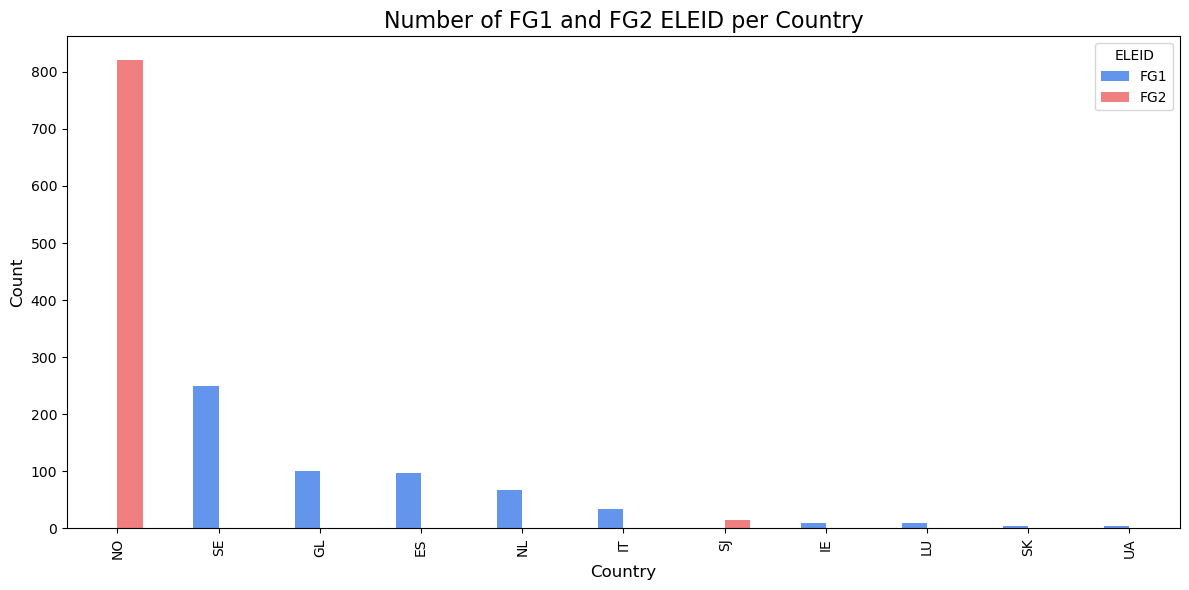

In [5]:
# ---------------
# Import metadata
# ---------------

fnames = pooch.retrieve(url=eca_url, known_hash=None, processor=pooch.Unzip())

# ------------------------------
# Extract metadata in df_sources
# ------------------------------

(fname,) = [fname for fname in fnames if "sources" in fname]
df_sources = pd.read_fwf(
    fname,
    colspecs=list(col_dict.values()),
    skiprows=24,
    names=list(col_dict),
)

# -------------------------------------------------------------------------------
# Convert latitutde and longitude from degrees:minutes:seconds to decimal degrees
# -------------------------------------------------------------------------------
for col in ["LAT", "LON"]:
    df_sources[col] = df_sources[col].apply(dms_to_decimal)

# ----------------------------------
# Convert START and STOP to datetime
# ----------------------------------
for col in ["START", "STOP"]:
    df_sources[col] = pd.to_datetime(df_sources[col], format="%Y%m%d")

# ---------------------------------
# Filter FG1 and FG2 (best quality)
# ---------------------------------
df_plot = df_sources[df_sources["ELEID"].isin(["FG1", "FG2"])]

# ---------------------------------------------------------------
# Group by country (CN) and quality flag (ELEID) to count entries
# ---------------------------------------------------------------

df_plot = df_plot.groupby(["CN", "ELEID"]).size().unstack(fill_value=0)

# ------------------------------
# Add total count and sort by it
# ------------------------------
df_plot["Total"] = df_plot.sum(axis=1)
df_plot = df_plot.sort_values(by="Total", ascending=False).drop(columns="Total")

# ------------------------------------------------------
# Plot number of stations by country and by quality flag
# ------------------------------------------------------

df_plot.plot(
    kind="bar",
    stacked=False,
    color={"FG1": "cornflowerblue", "FG2": "lightcoral"},
    figsize=(12, 6),
)

# Customize the plot
plt.title("Number of FG1 and FG2 ELEID per Country", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=90)
plt.legend(title="ELEID")
plt.tight_layout()

del df_plot

#### Import daily weather station data for target country (Norway)

Following the filtering based on metadata, the daily 10m wind speed observations for all qualifying stations in Norway are imported. The data retrieval process involves:
 - downloading individual station files;
 - converting them into a structured xarray dataset;
 - subset the time dimension to align with the core analysis period of 1985 to 2023
 - convert the coordinates of the stations, originally in degrees-minutes-seconds format, to decimal degrees in orderto facilitate the subsequent extraction of reanalysis data at these precise locations.

In [6]:
# ------------------------------------------------------
# Identify filenames for weather stations in Norway (NO)
# ------------------------------------------------------
country_code = "NO"
country_stations_meta = df_sources[df_sources["CN"] == country_code]

# Ensure the source id's SOUID values are strings (in case some are not)
country_stations_id = country_stations_meta["SOUID"].astype(str).tolist()

# Filter filenames that contain any of the SOUID string in the selected stations
country_fnames = [
    fname
    for fname in fnames
    if any(f"SOUID{id_}" in fname for id_ in country_stations_id)
]


# -----------------
# Import daily data 
# -----------------

# Each weather station derives attrbutes from the corresponding row of country_stations


dataarrays = []
for fname in tqdm.tqdm(country_fnames):
    # Read CSV into a DataFrame
    df = pd.read_csv(fname, skipinitialspace=True, skiprows=18)

    # Convert DATE to datetime format
    df["DATE"] = pd.to_datetime(df["DATE"], format="%Y%m%d")

    # Filter out missing values
    df = df[df["FG"] != -9999]

    # Optionally use SOUID or STAID as the label if available
    souid = df["SOUID"].iloc[0]

    # Extract metadata for the current stattion
    meta = country_stations_meta[country_stations_meta["SOUID"] == souid].iloc[0]

    # Convert to DataArray
    da = xr.DataArray(
        data=df["FG"].values,
        coords={"time": df["DATE"].values},
        dims=["time"],
        name="FG",
    )
    da = da.expand_dims(station=[str(souid)])
    da = da.assign_coords({k: ("station", [v]) for k, v in meta.items()})
    dataarrays.append(da)

obs = xr.concat(dataarrays, "station").sel(time=slice(start, stop))
obs["LON"].attrs["standard_name"] = "longitude"
obs["LAT"].attrs["standard_name"] = "latitude"
grid_out = obs.to_dataset().drop_dims("time")[["LAT", "LON"]]
del dataarrays, df_sources

100%|██████████| 821/821 [01:05<00:00, 12.48it/s]
/data/wp5/.tmp/ipykernel_3685741/336796630.py:53: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  obs = xr.concat(dataarrays, "station").sel(time=slice(start, stop))


#### Filter weather stations with sufficient high-rate of available records

To maintain the integrity of the statistical analysis, a final quality filter is applied to the station data. Stations with an excessive number of missing records (defined as more than 5 years' worth of daily data, or 1825 missing values) over the 39-year period are excluded from the analysis. This step ensures that the computed statistics for each station (e.g., mean wind speed, variability) are representative and not unduly biased by data gaps. The application of this filter results in a refined set of weather stations that are both high-quality and data-rich, providing a reliable observational baseline for comparison.

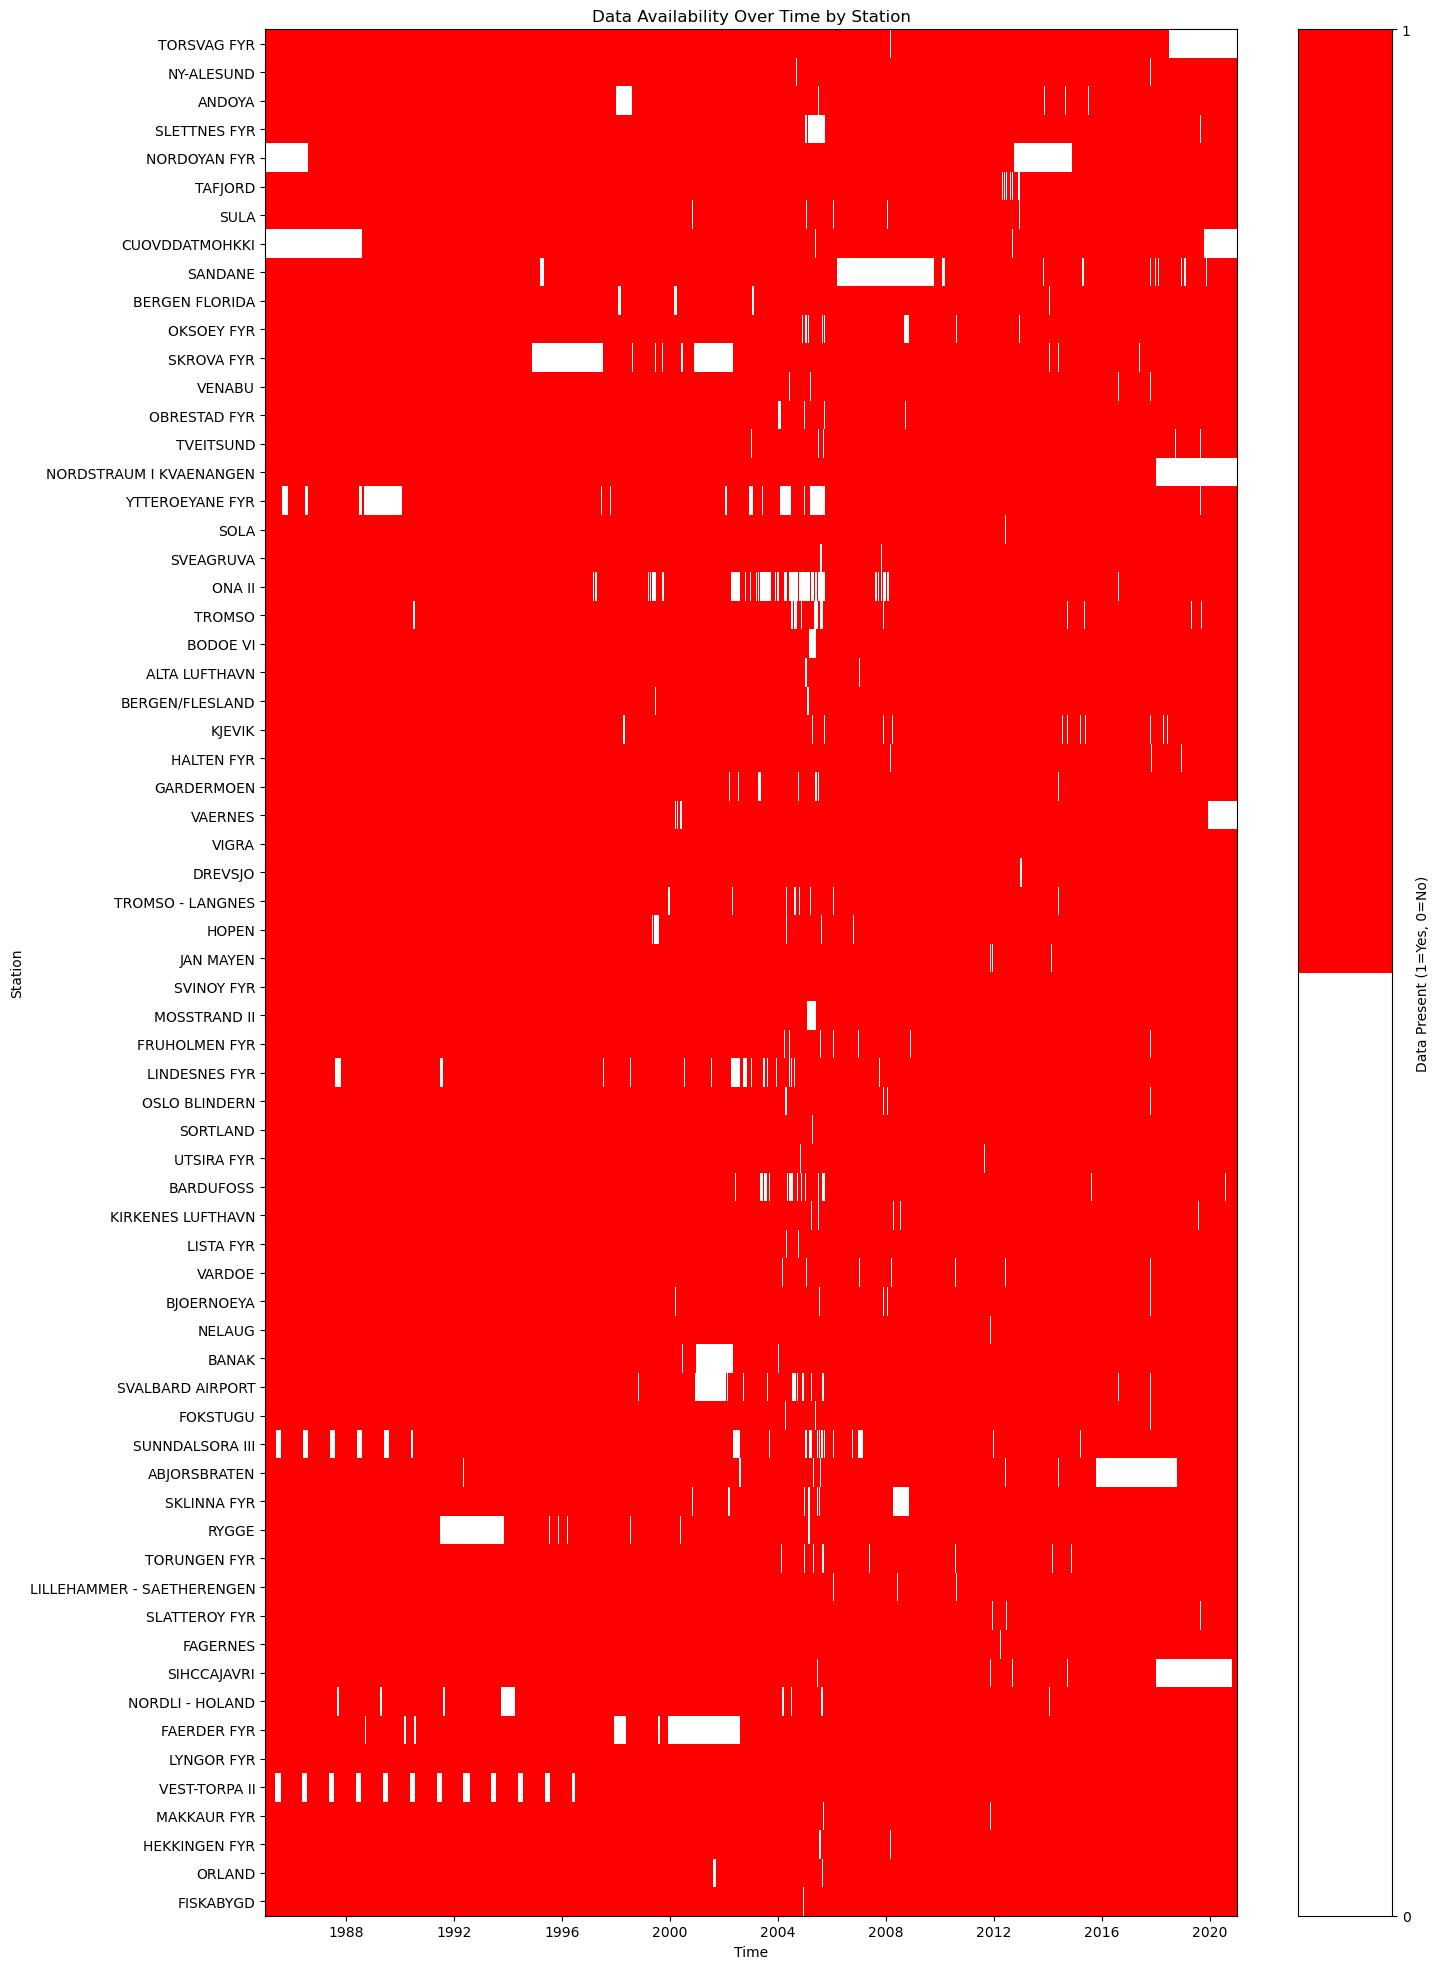

In [7]:
obs = obs.where(obs.isnull().sum("time") < max_nans, drop=True)

# ----
# Plot
# ----

cmap = ListedColormap(
    [
        (1, 0, 0, 0),  # Transparent for NaN    (0)
        (1, 0, 0, 1),  # Red for available data (1)
    ]
)
plt.figure(figsize=(15, obs.sizes["station"] * 0.3))
plt.imshow(
    obs.notnull().squeeze(),
    aspect="auto",
    interpolation="none",
    extent=[*obs["time"].values[[0, -1]], 0, obs.sizes["station"]],
    cmap=cmap,
)

# Ticks and labels
plt.yticks(np.arange(obs.sizes["station"]) + 0.5, obs["SOUNAME"].values)
plt.xlabel("Time")
plt.ylabel("Station")
plt.title("Data Availability Over Time by Station")
plt.colorbar(label="Data Present (1=Yes, 0=No)", ticks=[0, 1])
plt.tight_layout()
plt.show()

#### Map weather stations

A map of the selected stations is then generated, which confirms a well-distributed network suitable for comparing with CERRA’s spatial grid.

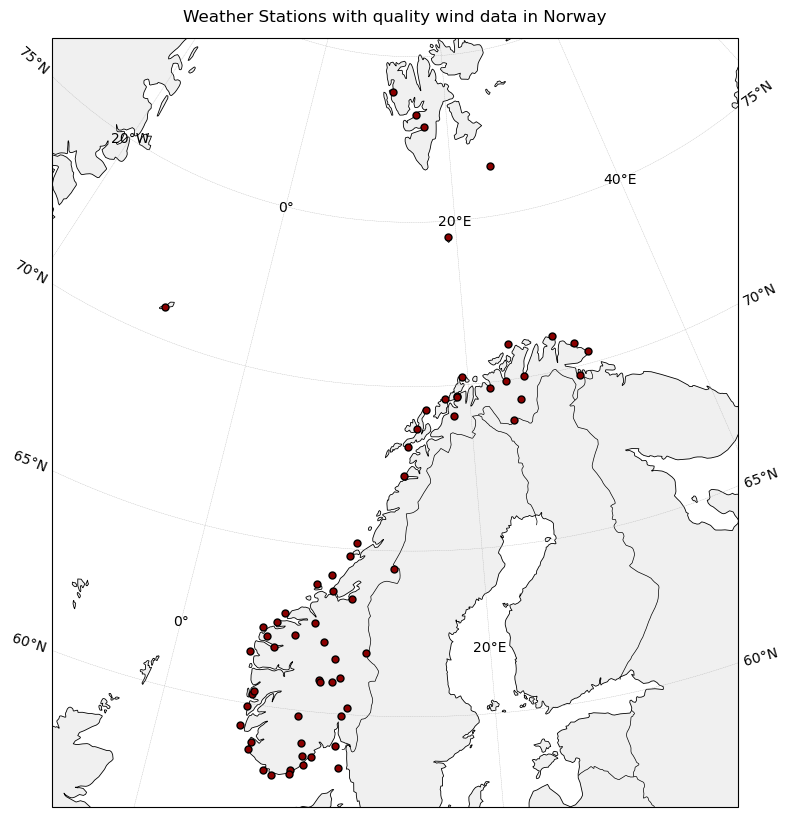

In [8]:
# ------------------------
# Extract station metadata
# ------------------------

lats = obs["LAT"].values  # latitude  (shape: n_stations,)
lons = obs["LON"].values  # longitude
names = obs["SOUNAME"].values  # station names

# ----------
# Create map
# ----------

# Define the Lambert-Conformal projection
proj = ccrs.LambertConformal(
    central_longitude=15,  # roughly the middle of Norway
    central_latitude=67,  # latitude of balance
    standard_parallels=(60, 80),  # secant cone cuts; tweak if needed
)

fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=proj)

# Focus on mainland and northern Norway
ax.set_extent([-5, 33, 57, 80], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="#f0f0f0")
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.25, linestyle="--")

# Plot the station locations
ax.scatter(
    lons,
    lats,
    s=25,
    color="darkred",
    edgecolors="k",
    zorder=3,
    transform=ccrs.PlateCarree(),
)

 #Optional Annotate each station
#for lon, lat, name in zip(lons, lats, names):
#    ax.text(
#        lon + 0.25, lat + 0.15, name,
#        fontsize=6, transform=ccrs.PlateCarree(), zorder=4
#    )

ax.set_title("Weather Stations with quality wind data in Norway", pad=12)
plt.tight_layout()
plt.show()

(section-3)=
### 3. Import reanalysis and extract data at weather station sites

Reanalysis data from CERRA and ERA5 are imported from the Copernicus Climate Data Store (CDS) using the c3s_eqc_automatic_quality_control module.
To ensure a fair comparison with the point-based station observations, gridpoint values from each reanalysis are extracted at the nearest grid cell to every station location.

- For CERRA, which has a horizontal resolution of 5.5 km, the nearest-neighbour extraction method (nearest_s2d) provides locally representative values.

 - For ERA5, with a coarser 31 km grid, the pre-processed single-point time series are obtained directly from the CDS. 

All datasets are harmonized in time (daily means) and variable naming conventions. The data are stored as xarray objects, ready for temporal and statistical comparison with the observed station records.

#### Import CERRA

As CERRA is produced at high temporal resolution (6-hourly), the data is downloaded for the four synoptic times (00:00, 06:00, 12:00, 18:00 UTC) covering the period 1985-2023. A critical processing step involves regridding the CERRA data onto the locations of the weather stations using a nearest neighbour remapping method. Following regridding, the 6-hourly values are averaged to compute the daily mean wind speed, thereby creating a daily time series at each station location that is directly comparable to the daily station observations.

In [9]:
# Import CERRA at the nearest grid points to se
request = download.update_request_date(cerra_request, start, stop, stringify_dates=True)
ds = download.download_and_transform(
    cerra_id,
    request,
    transform_func=extract_daily_stations,
    transform_func_kwargs={
        "grid_out": grid_out,
        "method": "nearest_s2d",
        "locstream_out": True,
    },
    chunks={"year": 1, "month": 1},
    drop_variables=["step"],
    cached_open_mfdataset_kwargs={
        "concat_dim": "forecast_reference_time",
        "combine": "nested",
        "data_vars": "minimal",
        "coords": "minimal",
        "compat": "override",
    },
)
(cerra,) = ds.sel(station=obs["station"]).data_vars.values()

100%|██████████| 432/432 [00:41<00:00, 10.49it/s]


#### Import ERA5

For a broader context, data from the global ERA5 reanalysis is also incorporated. To efficiently obtain long time series for specific points, the pre-processed ERA5 hourly time-series dataset is used. Since 10m wind speed is not a direct variable in this product, the u and v components of the 10m wind are retrieved. The daily mean wind speed is then calculated from these components, and subsequently averaged to a daily resolution. 

This results in a parallel set of daily wind speed time series for the ERA5 reanalysis at the same weather station locations.


In [10]:
datasets = []
for station, da_station in tqdm.tqdm(obs["station"].groupby("station")):
    ds = download.download_and_transform(
        era5_id,
        era5_request
        | {
            "location": {
                "longitude": da_station["LON"].item(),
                "latitude": da_station["LAT"].item(),
            }
        },
        transform_func=compute_wind_speed,
        quiet=True,
    )
    datasets.append(ds.expand_dims(station=[station]))
(era5,) = xr.concat(datasets, "station").data_vars.values()

100%|██████████| 66/66 [00:03<00:00, 16.72it/s]
/data/wp5/.tmp/ipykernel_3685741/345914223.py:16: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  (era5,) = xr.concat(datasets, "station").data_vars.values()


(section-4)=
### 4. Results

This section shows the core findings of the intercomparison of the performance of the CERRA and ERA5 reanalyses against the weather station observations.

#### Organize data for the analysis

To facilitate a streamlined comparison, the observational and reanalysis datasets are consolidated into a single data structure. The daily time series of 10m wind speed from the weather stations (OBS), CERRA, and ERA5 are combined, aligning them chronologically and by station. This unified dataset allows for the direct computation of comparative statistics and the generation of insightful visualizations.

In [11]:
da = xr.concat(
    [
        cerra.expand_dims(product=["CERRA"]).rename(forecast_reference_time="time"),
        obs.expand_dims(product=["OBS"]).rename(cerra.name) / 10,
        era5.expand_dims(product=["ERA5"]),
    ],
    "product",
)
da["time"].attrs = {"long_name": "time"}
da = da.compute()
#del cerra, era5, obs

/data/wp5/.tmp/ipykernel_3685741/1269578046.py:1: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'station' ('station',) The recommendation is to set join explicitly for this case.
  da = xr.concat(
/data/wp5/.tmp/ipykernel_3685741/1269578046.py:1: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  da = xr.concat(


#### Compare weather station data with reanalyses

The two reanalyses are compared with observations using scatterplots. For every season, and for different statistics of the wind speed (mean, variance, minimum and maximum), CERRA and ERA5 values are plotted against the observed counterparts. The visualization used to present these results is a scatter plot, which compares the long-term statistical metric from the reanalysis against the same metric from the observations for all stations. 

The plots show the observed the wind speed statistics on the x-axis and the corresponding statistics for the reanalysis on the y-axis. A perfect agreement would see all points lying on the 1:1 line. Each plot shows:

 - *linear regression*  fitted to the data points for both reanalyses, providing a quantitative measure of the relationship;

 - *the coefficient of Determination (R²)* computed to indicate how well the variability in the observations is explained by the reanalysis;

 - *outlier identification* corresponding to the stations with the largest residuals (difference between the reanalysis value and the observed value) annotated on the plot, helping to identify locations where the models perform poorly, potentially due to local topography or exposure issues not captured by the model grid;

 - *seasonal analysis*  conducted for different seasons (e.g., DJF, MAM, JJA, SON) to assess whether the performance of the reanalyses is consistent year-round or exhibits seasonal dependencies.

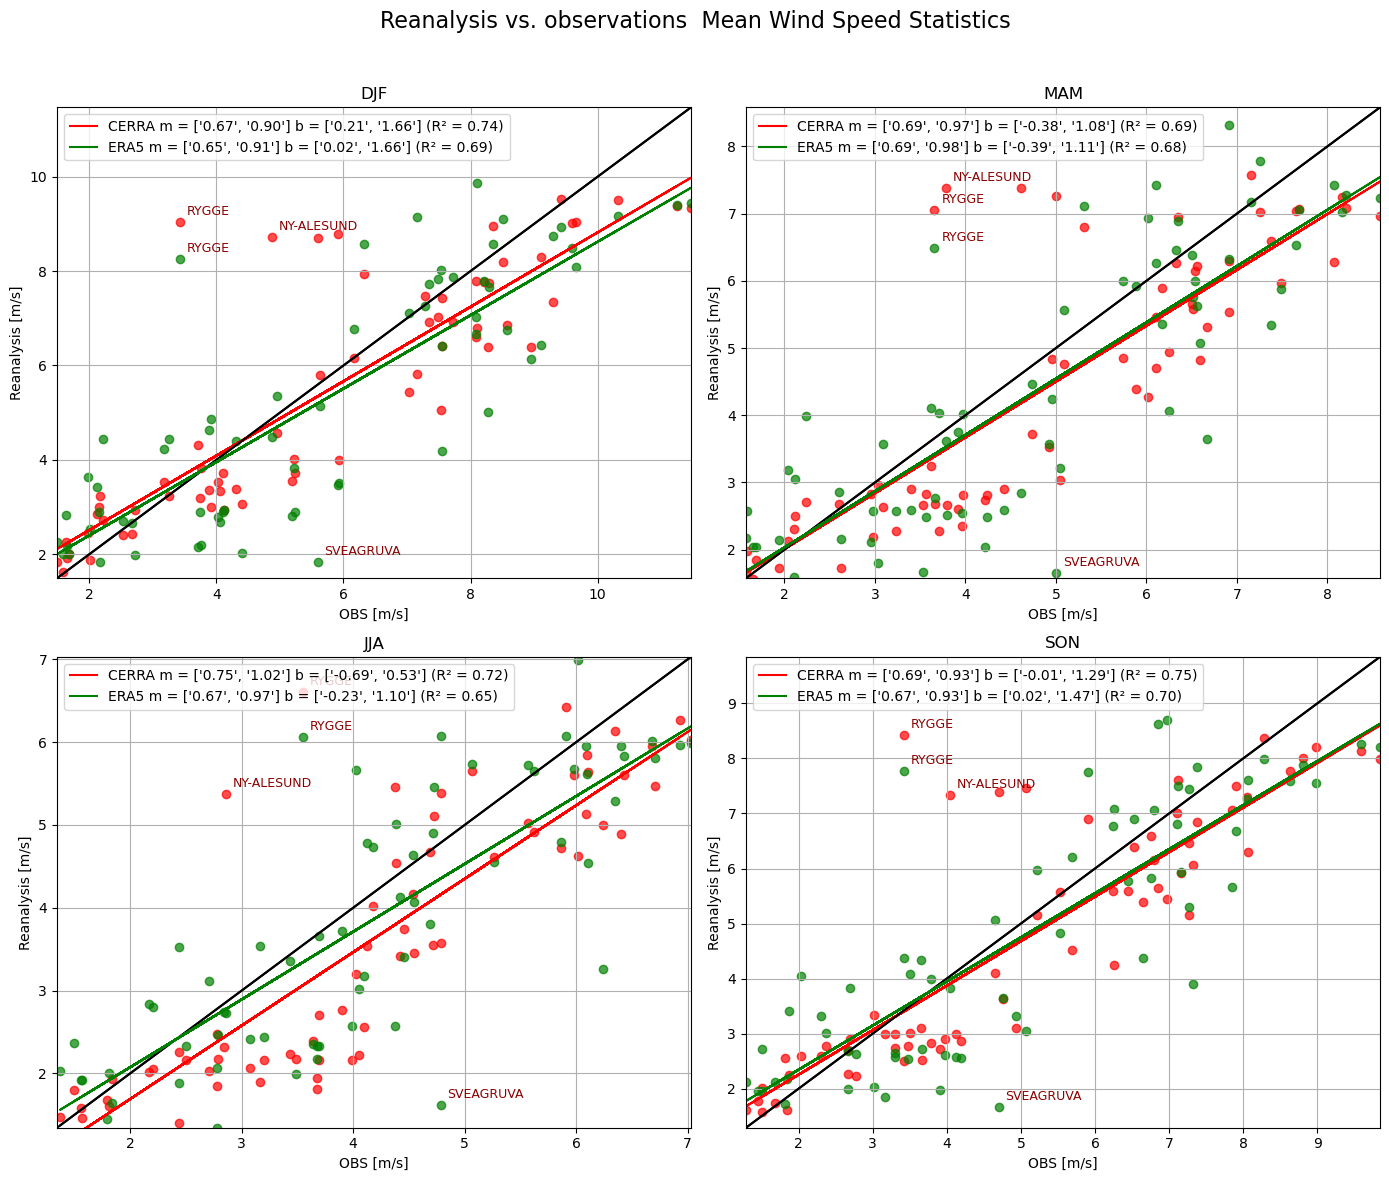

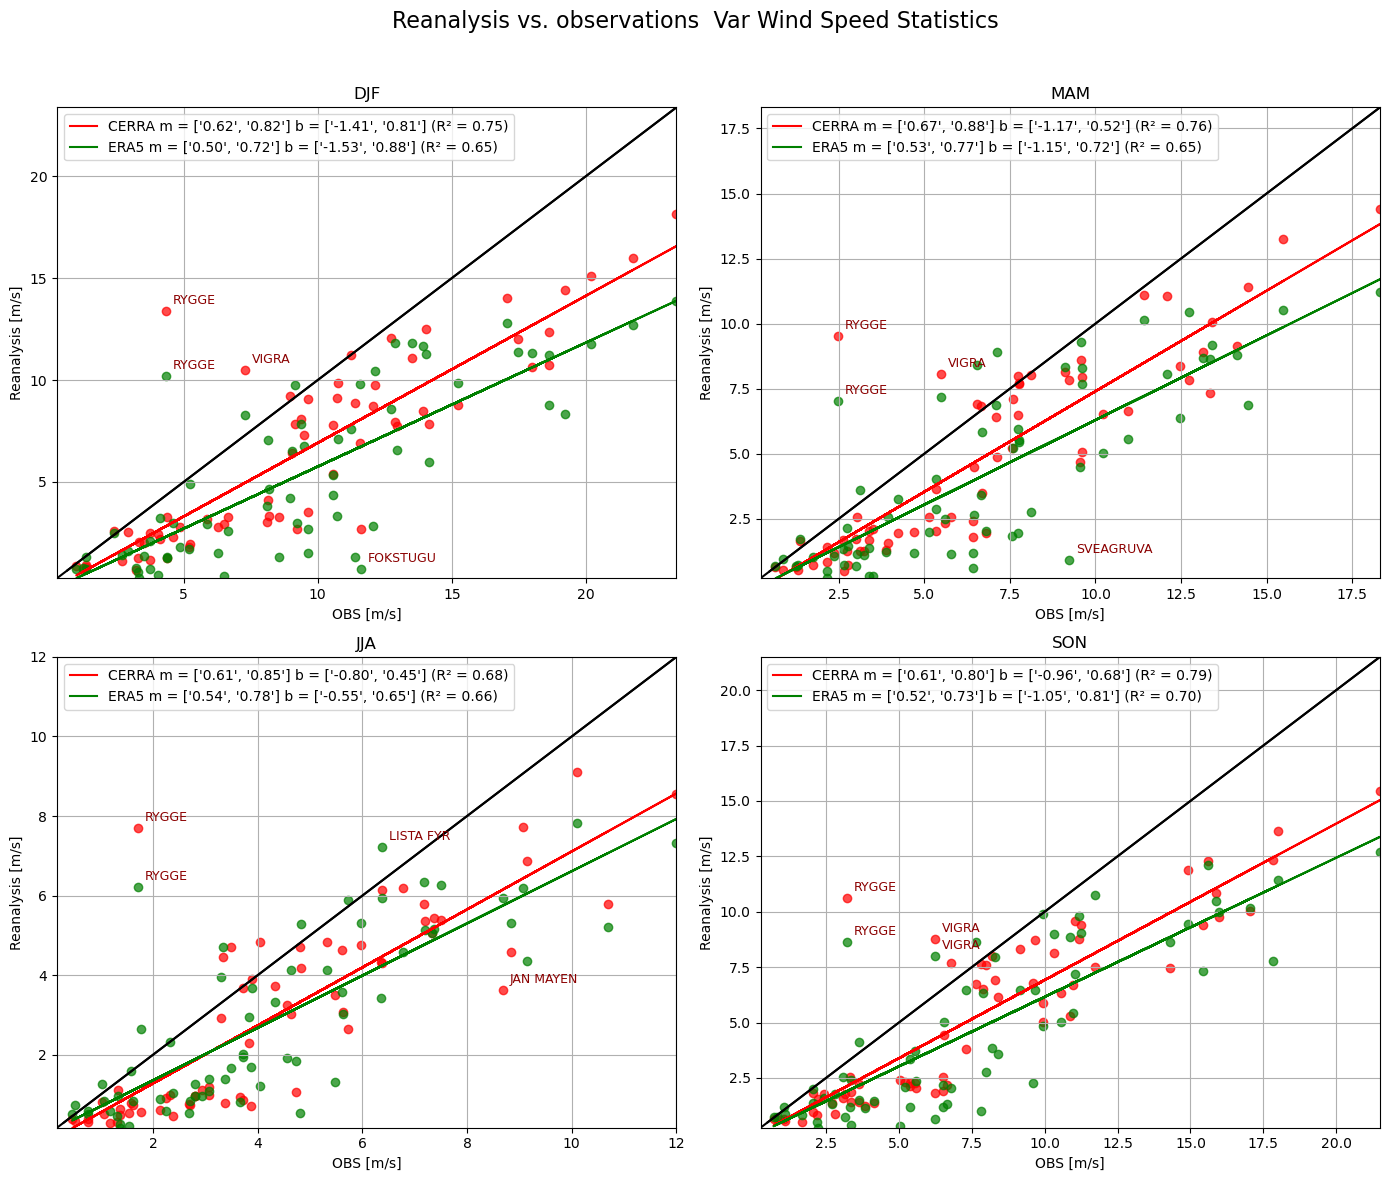

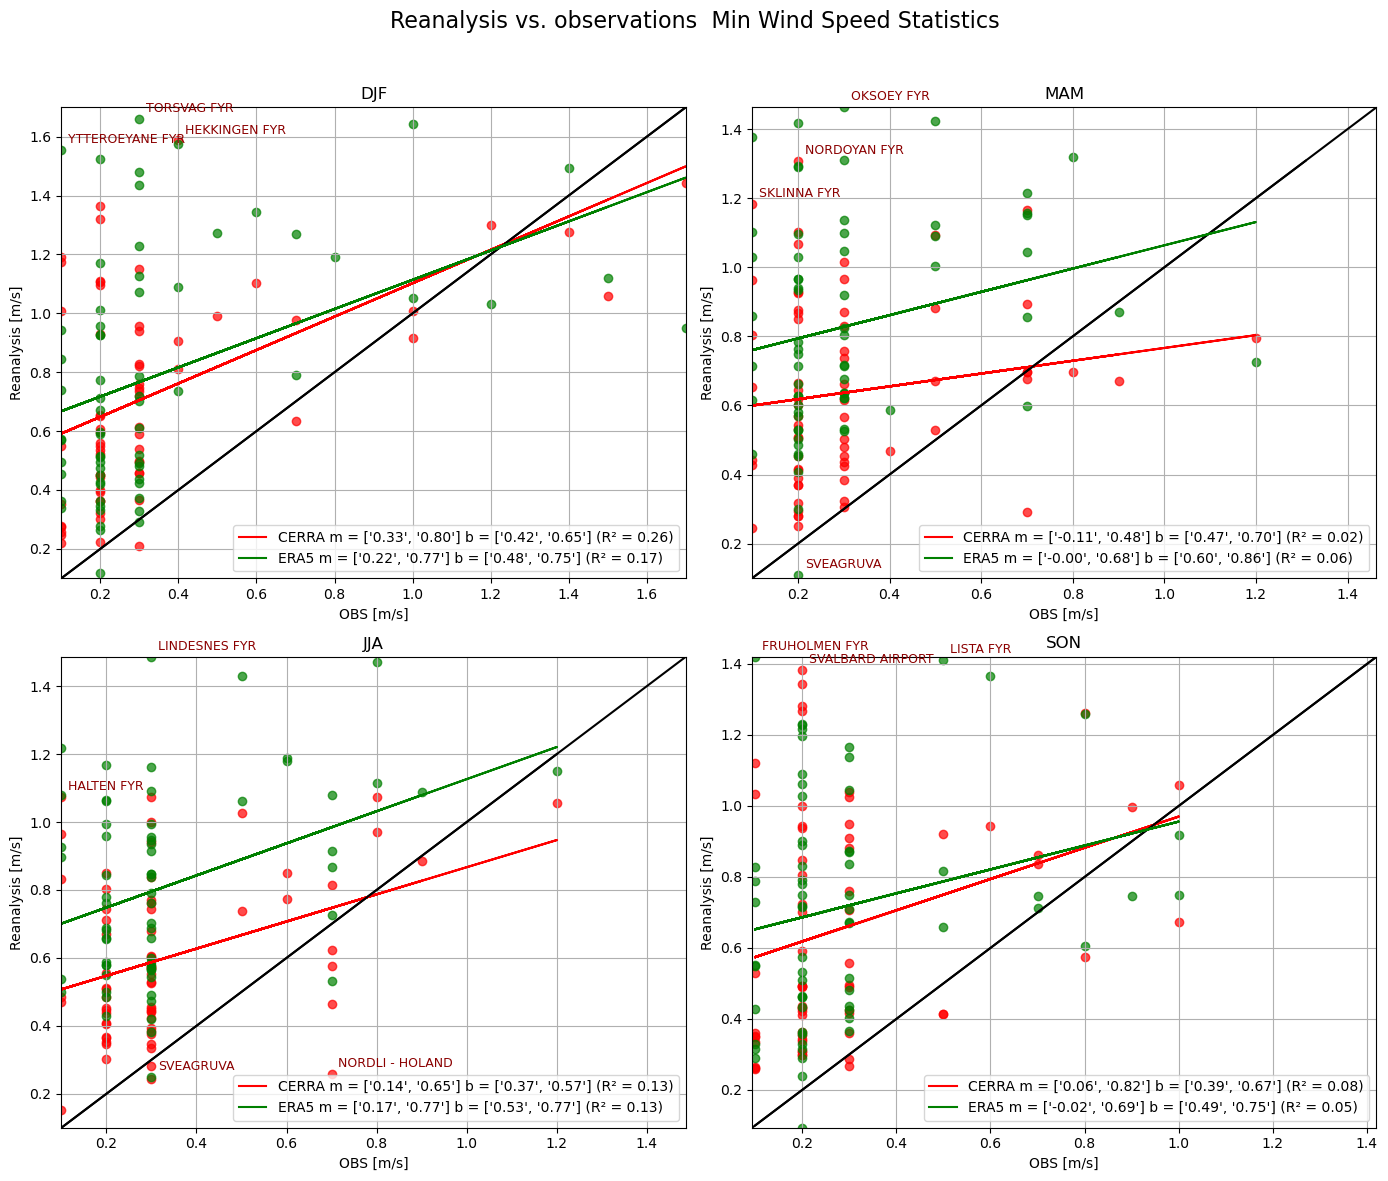

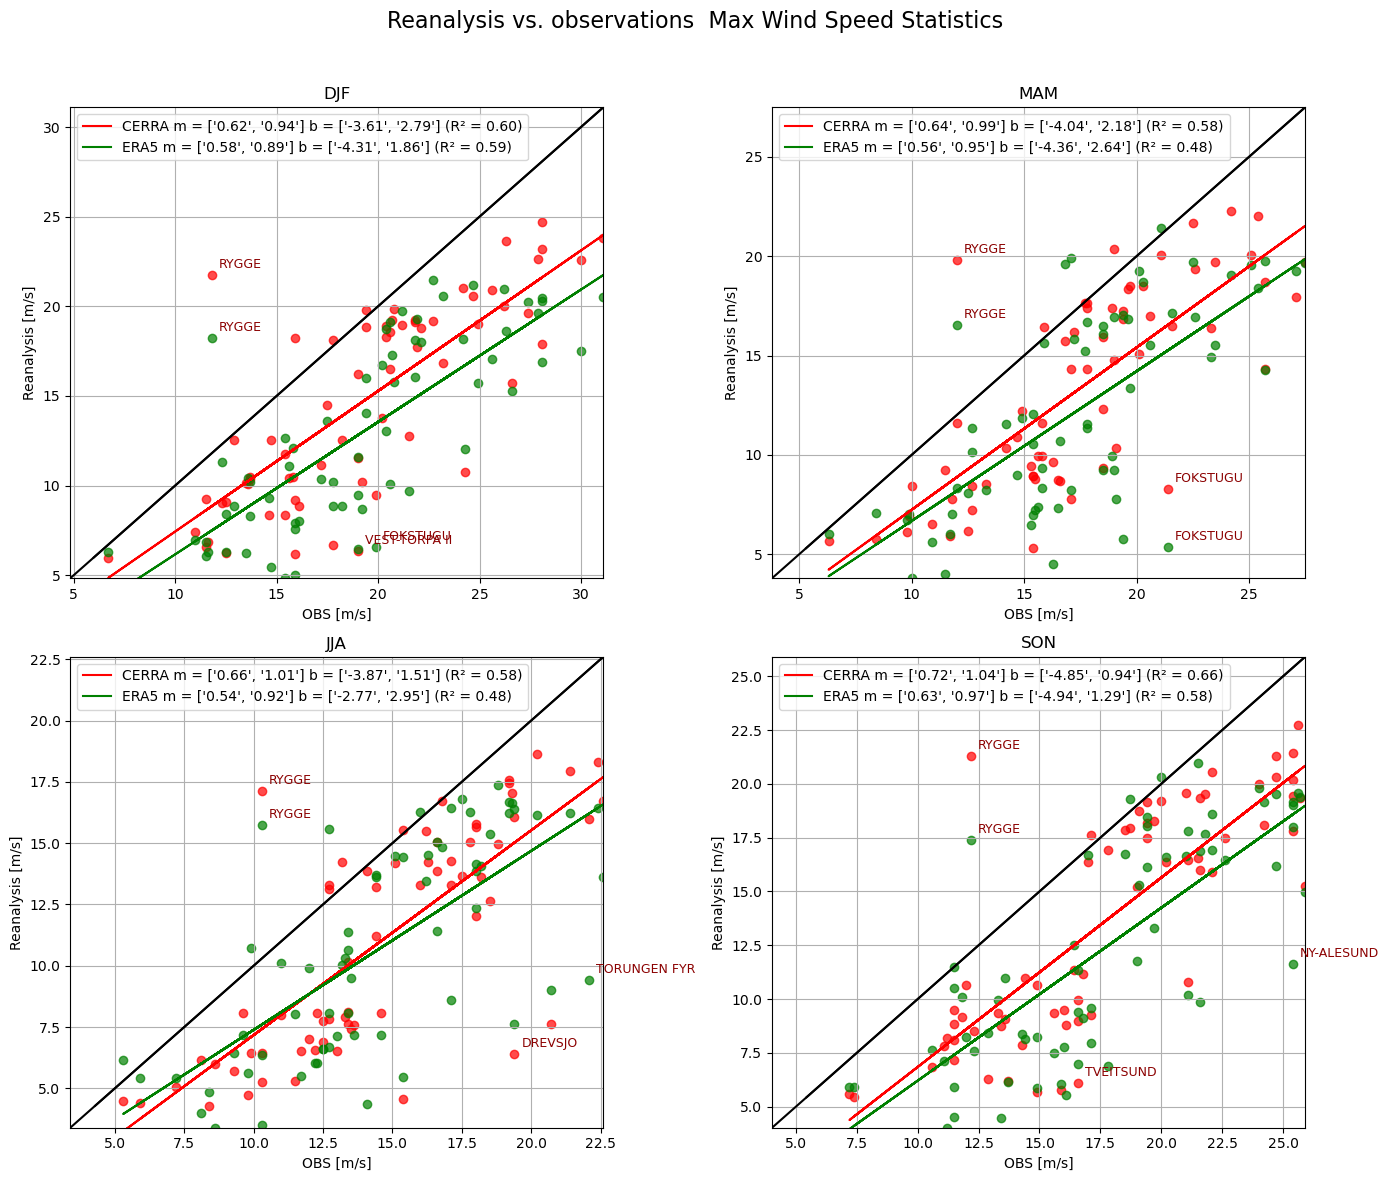

In [12]:
# List of statistics to compare
statistics = ["mean", "var", "min", "max"]
seasons = ["DJF", "MAM", "JJA", "SON"]
targets = {"CERRA":"r", "ERA5": "g"}

for j, stat in enumerate(statistics):
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()

    # Plot each statistic in a subplot
    for i, season in enumerate(seasons):
        compare_statistic_scatter(
            da,
            "OBS",
            targets,
            stat=stat,
            top_n_outliers=2,
            ax=axes[i],
            season=season,
        )

    plt.suptitle(
        f"Reanalysis vs. observations  {stat.capitalize()} Wind Speed Statistics", fontsize=16
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

#### Discussion

The statistical analysis of daily wind speed data reveals a nuanced performance difference between the CERRA and ERA5 reanalysis datasets. For mean wind speeds at each station, the differences between CERRA and ERA5 are not significant. However, a marked contrast emerges in their ability to represent wind speed variance, a critical metric for atmospheric variability.

The comparison of seasonal wind speed variance against station observations demonstrates that CERRA (represented in red) consistently outperforms ERA5 (green). Across all seasons, CERRA's data points align more closely with the 1:1 reference line, indicating a superior representation of the observed spread in daily wind speeds. This is quantitatively supported by higher coefficients of determination (R²), which range from approximately 0.68 to 0.79 for CERRA compared to 0.65–0.70 for ERA5. Furthermore, the regression slopes for variance in CERRA (approximately 0.6–0.7) are consistently steeper than those for ERA5 (0.5–0.54). This indicates that CERRA captures a greater portion of the observed variance and mitigates the systematic underestimation (variance damping) evident in ERA5, a common issue in coarser-resolution global models that struggle to resolve mesoscale processes [5](https://doi.org/10.1002/qj.3616).

Seasonally, the strongest agreement is observed in autumn (SON), where CERRA's R² peaks at 0.79. While performance dips during summer (JJA) for both models, CERRA maintains a relative advantage, particularly at sites with higher observed variance. A persistent outlier is noted for the Rygge station, which may be attributable to local topographic effects not fully resolved by either reanalysis system [6](https://doi.org/10.1175/JAMC-D-11-084.1).

The performance diverges further for extreme wind statistics. For maximum wind speeds, CERRA shows consistently better performance, which is crucial for load and resilience calculations. Conversely, both reanalyses perform poorly in replicating minimum wind speeds (calm conditions), with R² values as low as 0.02, suggesting that physical processes like stable boundary layer dynamics remain a significant challenge for modern reanalysis products.

From an energy assessment perspective, these findings are highly relevant. Wind power generation is non-linearly related to wind speed and is critically dependent on its variability, which dictates intermittency and ramp events. CERRA's enhanced ability to reproduce observed variance and extreme values translates to greater reliability for key applications such as wind resource assessment, turbine siting, power output forecasting, and grid integration studies. The reduced variance bias in CERRA suggests it can provide a more realistic forcing for regional climate and energy system models, ultimately leading to lower uncertainty in energy yield predictions.


## ℹ️ If you want to know more

### Key resources

* The [Equropean Climate Assessment & Dataset](https://www.ecad.eu/) provides daily observations at meteorological stations throughout Europe and the Mediterranean.

* The [ERA5 hourly time-series data on single levels from 1940 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-timeseries?tab=overview) is a regridded subset of the full ERA5 that is stored in a format designed for retrieving long time-series for a single point.

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.1002/we.2759) Davidson, M. R., & Millstein, D. (2022). Limitations of reanalysis data for wind power applications. Wind Energy, 25(9), 1646-1653.

[[2]](https://doi.org/10.2139/ssrn.5131628) Patra, A., Oueslati, B., Chevallier, T., Renaud, P., Kervella, Y., & DUBUS, L. Evaluation of Era5, Cosmo-Rea6 and Cerra in Simulating Wind Speed Along the French Coastline for Wind Energy Applications. Cosmo-Rea6 and Cerra in Simulating Wind Speed Along the French Coastline for Wind Energy Applications.

[[3]](https://doi.org/10.5194/asr-20-109-2023) Spangehl, T., Borsche, M., Niermann, D., Kaspar, F., Schimanke, S., Brienen, S., ... & Brast, M. (2023). Intercomparing the quality of recent reanalyses for offshore wind farm planning in Germany's exclusive economic zone of the North Sea. Advances in Science and Research, 20, 109-128.

[[4]](https://doi.org/10.1016/j.energy.2025.136746) Pereira, H., Alvarez, I., Aldao, E., Sousa, M. C., Picado, A., Lorenzo, N., ... & Dias, J. M. (2025). Analysis of wind conditions for safe drone operation in offshore wind farms on the Spanish Atlantic coast. Energy, 136746.

[[5]](https://doi.org/10.1002/qj.3616) Ramon, J., Lledó, L., Torralba, V., Soret, A., & Doblas-Reyes, F. J. (2019). What global reanalysis best represents near-surface winds?. Quarterly Journal of the Royal Meteorological Society, 145(724), 3236-3251.

[[6]](https://doi.org/10.1175/JAMC-D-11-084.1) Jiménez, P. A., & Dudhia, J. (2012). Improving the representation of resolved and unresolved topographic effects on surface wind in the WRF model. Journal of Applied Meteorology and Climatology, 51(2), 300-316.